In [ ]:
# ID                Name
# 6531501217      Khant Zay Lin
# 6531501218      Khun Min Khant Zaw
# 6531501204      Aung Phyo Linn
# 6531501231      Taryar Thaw Zin
# 6531501237      Zwe Lulin Maung


Dataset loaded successfully.

Checking for Multicollinearity (VIF):
                     feature         VIF
21         PerformanceRating  123.081900
12                  JobLevel   52.568161
20         PercentSalaryHike   42.319297
0                        Age   33.328299
16             MonthlyIncome   32.087193
26           WorkLifeBalance   15.618528
11            JobInvolvement   15.108312
24         TotalWorkingYears   14.602522
3                 Department   12.973763
10                HourlyRate   11.278610
27            YearsAtCompany   10.580184
5                  Education    9.487323
13                   JobRole    8.078983
22  RelationshipSatisfaction    7.288717
8    EnvironmentSatisfaction    7.123545
14           JobSatisfaction    7.027051
1             BusinessTravel    6.744893
30      YearsWithCurrManager    6.495977
28        YearsInCurrentRole    6.439935
15             MaritalStatus    5.812187
25     TrainingTimesLastYear    5.728617
17               MonthlyRate  

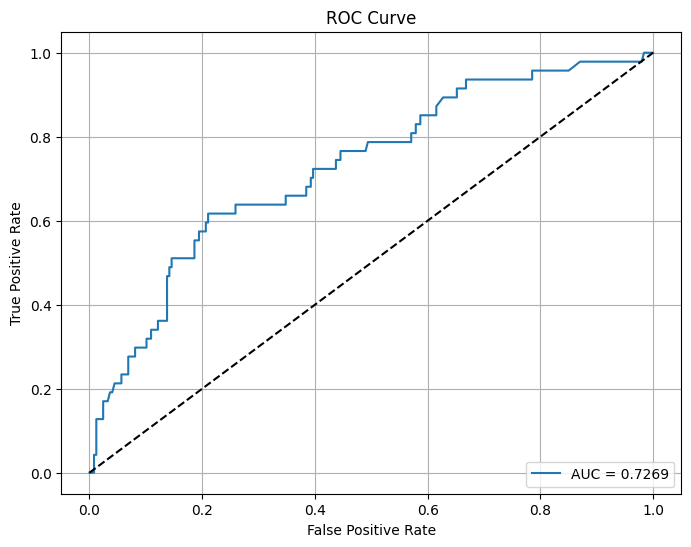


Model (best from search), Scaler, and Mappings saved successfully.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================================================================
# Load the dataset
# =============================================================================
try:
    data = pd.read_csv('HR-Employee-Attrition 3.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'HR-Employee-Attrition 3.csv' not found.")
    exit()

# Drop constant columns (EmployeeCount, StandardHours, Over18 are typically constant in this dataset)
data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1)

# =============================================================================
# Data Preprocessing (before VIF - encoding categoricals)
# =============================================================================
# Encode the target variable 'Attrition'
le_attrition = LabelEncoder()
data['Attrition'] = le_attrition.fit_transform(data['Attrition'])

# Identify categorical columns for encoding (object dtype)
categorical_cols = data.select_dtypes(include='object').columns
categorical_mappings = {}
# Apply label encoding and store mappings for VIF calculation and later use
for col in categorical_cols:
    le = LabelEncoder()
    # Apply label encoding
    data[col] = le.fit_transform(data[col])
    # Store the mapping for deployment
    categorical_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


# =============================================================================
# Multicollinearity Check (Calculate VIF BEFORE dropping correlated features)
# =============================================================================
print("\nChecking for Multicollinearity (VIF):")

data_numeric_for_vif = data.select_dtypes(include=np.number)

# Drop the target variable 'Attrition' as it's not an independent variable for VIF
if 'Attrition' in data_numeric_for_vif.columns:
    data_numeric_for_vif = data_numeric_for_vif.drop('Attrition', axis=1)

# Ensure there are columns left to calculate VIF
if data_numeric_for_vif.shape[1] > 0:
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = data_numeric_for_vif.columns
    # Use the values for faster computation with statsmodels VIF
    X_for_vif = data_numeric_for_vif.values

    # Calculate VIF for each column
    vif_data["VIF"] = [variance_inflation_factor(X_for_vif, i)
                       for i in range(X_for_vif.shape[1])]

    # Sort VIFs for easier viewing
    vif_data = vif_data.sort_values(by="VIF", ascending=False)

    print(vif_data)
    print("\nInterpretation of VIF Values:")
    print("- VIF = 1: No correlation between the feature and the others.")
    print("- VIF > 1: Correlation exists.")
    print("- VIF > 5 or > 10: Indicates potentially high multicollinearity (thresholds vary).")
else:
    print("No numerical columns available for VIF calculation after initial processing.")


# =============================================================================
# Data Preprocessing (after VIF - dropping features)
# =============================================================================
# Drop features identified as multicollinear or otherwise redundant based on analysis (and VIF results if used)
# Dropping Features with data understanding
data = data.drop(['MonthlyRate', 'HourlyRate'], axis=1)
print("\nDropped 'MonthlyRate' and 'HourlyRate' as intended.")


# =============================================================================
# Define Features and Target
# =============================================================================
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# =============================================================================
# Train-Test Split (BEFORE SMOTE)
# =============================================================================
# Split data into training and testing sets
# Use stratify=y to maintain the proportion of Attrition in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nOriginal Training set shape: {X_train.shape}, Target shape: {y_train.shape}")
print(f"Original Testing set shape: {X_test.shape}, Target shape: {y_test.shape}")
print(f"Attrition distribution in Training set:\n{y_train.value_counts(normalize=True)}")
print(f"Attrition distribution in Testing set:\n{y_test.value_counts(normalize=True)}")


# =============================================================================
# Apply SMOTE (ONLY to the training data AFTER the split)
# =============================================================================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"\nResampled Training set shape: {X_train_res.shape}, Target shape: {y_train_res.shape}")
print(f"Attrition distribution in Resampled Training set:\n{y_train_res.value_counts(normalize=True)}")


# =============================================================================
# Feature Scaling (Fit on resampled train, Transform train and original test)
# =============================================================================
scaler = StandardScaler()

# Fit the scaler ONLY on the resampled training data
X_train_res_scaled = scaler.fit_transform(X_train_res)

# Transform both the resampled training data and the original test data
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# Model Training with Hyperparameter Tuning
# =============================================================================
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    # Removed 'auto' as it's deprecated. 'sqrt' is equivalent and default.
    # Use 'sqrt' or 'log2' or None
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Initialize RandomizedSearchCV
# Fit the search object on the SCALED and RESAMPLED training data
model = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10, # Number of parameter settings that are sampled
    cv=3,       # Number of cross-validation folds
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

# Fit the model using the scaled and resampled training data
model.fit(X_train_res_scaled, y_train_res)

print("\nBest parameters found by RandomizedSearchCV:")
print(model.best_params_)

# =============================================================================
# Model Evaluation (Using the original, scaled test data)
# =============================================================================
# Predict on the SCALED original test set
y_pred = model.predict(X_test_scaled)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# =============================================================================
# Save the model, scaler, and mappings
# =============================================================================
# Save the best model found by RandomizedSearchCV
joblib.dump(model, 'employee_attrition_model.pkl')
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
# Save the categorical mappings
joblib.dump(categorical_mappings, 'categorical_mappings.pkl')

print("\nModel (best from search), Scaler, and Mappings saved successfully.")